In [1]:
import hera_cal as hc
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
np.random.seed(1)

In [3]:
def build_hex_array(hexNum, sep=14.7):
    antpos, i = {}, 0
    for row in range(hexNum-1,-(hexNum),-1):
        for col in range(2*hexNum-abs(row)-1):
            xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*sep;
            yPos = row*sep*3**.5/2;
            antpos[i] = np.array([xPos, yPos, 0])
            i += 1
    return antpos

In [4]:
def expand_red_vis(vis, reds):
    all_vis = {}
    for red in reds:
        for bl in red:
            all_vis[bl] = vis[red[0]]
    return hc.datacontainer.DataContainer(all_vis)

# Simulate 2-pol observation with delays

In [5]:
nTime, nFreq = 4, 20

antpos = build_hex_array(3)
reds = hc.redcal.get_reds(antpos, pols=['xx','yy'], pol_mode='2pol')
freqs = np.linspace(.1,.2,nFreq)
gains, true_vis, data = hc.redcal.sim_red_data(reds, gain_scatter=.1, shape=(nTime,nFreq))

true_delays = {ant: 100 * np.random.randn() for ant in gains.keys()} #in ns
true_delay_gains = {ant: np.reshape(np.exp(-2.0j * np.pi * freqs * delay), (1,len(freqs))) for ant,delay in true_delays.items()}
for ant1,ant2,pol in data.keys():
    data[(ant1,ant2,pol)] *= true_delay_gains[(ant1,pol[0])] * np.conj(true_delay_gains[(ant2, pol[1])])
for ant in gains.keys():
    gains[ant] *= true_delay_gains[ant]
    
delay_error_level = 1. # in ns
delay_slope_error_x = 0.0 # ns/m
guess_delays = {ant: true_delays[ant] + delay_slope_error_x*antpos[ant[0]][0] + delay_error_level * np.random.randn() for ant in gains.keys()} #in ns    
guess_gains = {ant: np.reshape(np.exp(-2.0j * np.pi * freqs * delay), (1,len(freqs))) for ant,delay in guess_delays.items()}

# Perform Redcal

In [6]:
rc = hc.redcal.RedundantCalibrator(reds)
sol0 = rc.logcal(data, sol0=guess_gains)
meta, sol = rc.lincal(data, sol0)
sol_rd = rc.remove_degen(antpos, sol, degen_sol=guess_gains)
g,v = hc.redcal.get_gains_and_vis_from_sol(sol_rd)
vis_sols = expand_red_vis(v, reds)
true_vis = expand_red_vis(true_vis, reds)

In [7]:
print np.mean(meta['chisq'])
print meta['iter']

1.35166439066e-26
19


# Perform Abscal

In [8]:
# todo: implement indepently for each polarization
# do we need a lincal for tt_phase? Or some other way of addressing phase wrap?

In [9]:
model = deepcopy(true_vis)
gain_list = []
AC = hc.abscal.AbsCal(model, deepcopy(vis_sols), antpos=antpos, freqs=freqs)

# AC.delay_lincal(medfilt=False, verbose=True, time_avg=True)
# AC.data = hc.abscal.apply_gains(AC.data, AC.ant_dly_gain, gain_convention='divide')
# gain_list.append(AC.ant_dly_gain)

AC.delay_slope_lincal(medfilt=True, verbose=True, time_avg=True)
AC.data = hc.abscal.apply_gains(AC.data, AC.dly_slope_gain, gain_convention='divide')
gain_list.append(AC.dly_slope_gain)

#AC.phs_logcal(avg=True, verbose=True)
#AC.data = hc.abscal.apply_gains(AC.data, AC.ant_phi_gain, gain_convention='divide')
#gain_list.append(AC.ant_phi_gain)

AC.abs_amp_logcal(verbose=True)
AC.data = hc.abscal.apply_gains(AC.data, AC.abs_eta_gain, gain_convention='divide')
gain_list.append(AC.abs_eta_gain)

AC.TT_phs_logcal(verbose=True, zero_psi=True)
AC.data = hc.abscal.apply_gains(AC.data, AC.TT_Phi_gain, gain_convention='divide')
gain_list.append(AC.TT_Phi_gain)

abscal_gain_dict = hc.abscal.merge_gains(gain_list)

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


# Examine Abscal Gain Solutions

In [10]:
abs_omni_gains = {ant: abscal_gain_dict[ant] * g[ant] for ant in g.keys()}

<IPython.core.display.Javascript object>


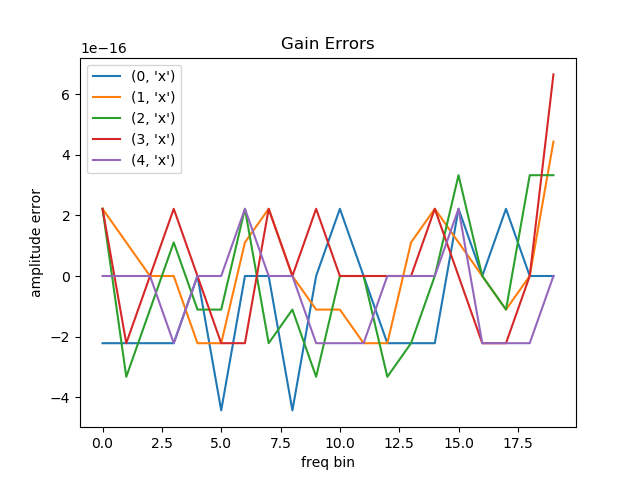

In [11]:
plt.figure()
for ant in [(i,'x') for i in range(5)]:
    plt.plot(np.abs(abs_omni_gains[ant][0,:]) - np.abs(gains[ant][0,:]), label=ant)
plt.title('Gain Errors')
plt.ylabel('amplitude error')
plt.xlabel('freq bin')

plt.legend()

<IPython.core.display.Javascript object>


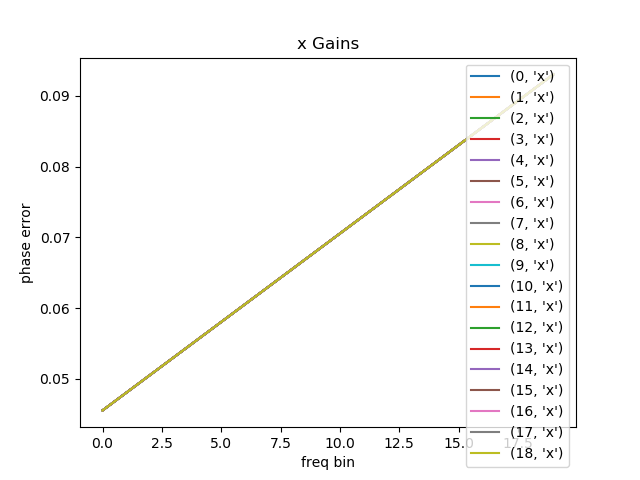

<IPython.core.display.Javascript object>


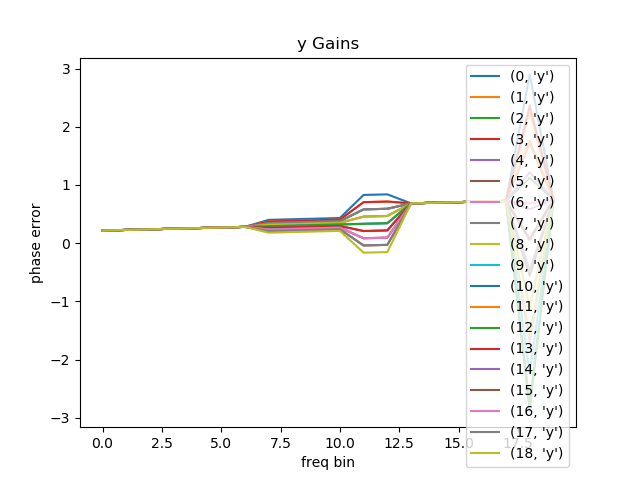

In [12]:
plt.figure()
for ant in [(i,'x') for i in range(19)]:
    plt.plot(np.angle(abs_omni_gains[ant][0,:] / gains[ant][0,:]), label=ant)
plt.title('x Gains')
plt.ylabel('phase error')
plt.xlabel('freq bin')
plt.legend()

plt.figure()
for ant in [(i,'y') for i in range(19)]:
    plt.plot(np.angle(abs_omni_gains[ant][0,:] / gains[ant][0,:]), label=ant)
plt.title('y Gains')
plt.ylabel('phase error')
plt.xlabel('freq bin')
plt.legend()

<IPython.core.display.Javascript object>


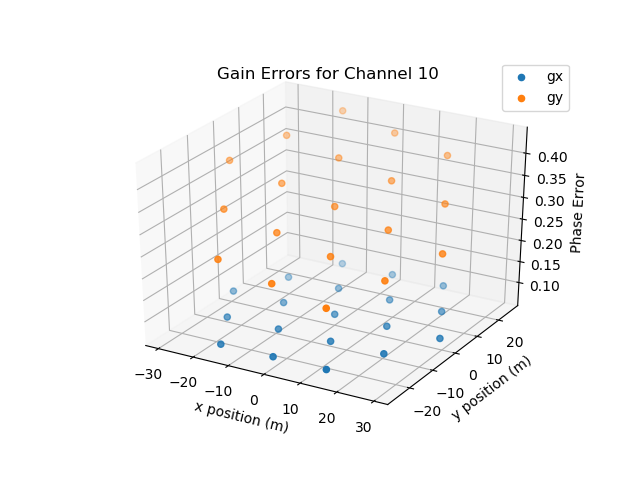

In [13]:
chan = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xpos = np.array([antpos[i][0] for i in range(len(antpos))])
ypos = np.array([antpos[i][1] for i in range(len(antpos))])
x_phs_errs = np.array([np.angle(abs_omni_gains[i,'x'][0,chan] / gains[i,'x'][0,chan]) for i in range(len(antpos))])
y_phs_errs = np.array([np.angle(abs_omni_gains[i,'y'][0,chan] / gains[i,'y'][0,chan]) for i in range(len(antpos))])
ax.scatter3D(xpos, ypos, x_phs_errs)
ax.scatter3D(xpos, ypos, y_phs_errs)
plt.title('Gain Errors for Channel ' + str(chan))
ax.set_xlabel('x position (m)')
ax.set_ylabel('y position (m)')
ax.set_zlabel('Phase Error')
plt.legend(['gx','gy'])

# Examine Abscaled Visibilities

<IPython.core.display.Javascript object>


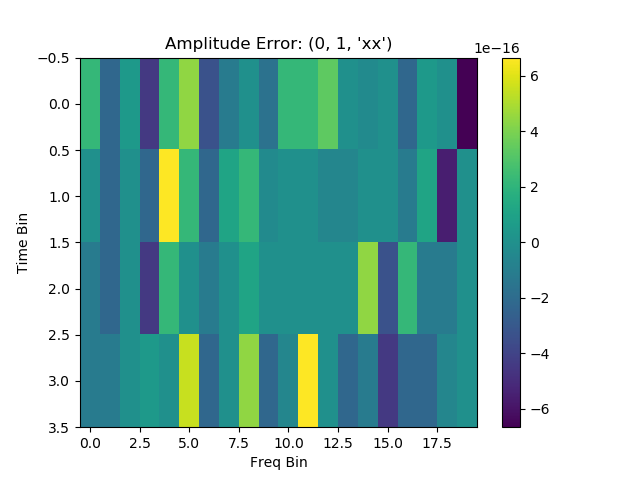

Text(0,0.5,u'Time Bin')

In [14]:
plt.figure()
bl = (0,1,'xx')
plt.imshow(np.abs(AC.data[bl])-np.abs(true_vis[bl]), aspect='auto')
plt.colorbar()
plt.title('Amplitude Error: ' + str(bl))
plt.xlabel('Freq Bin')
plt.ylabel('Time Bin')

<IPython.core.display.Javascript object>


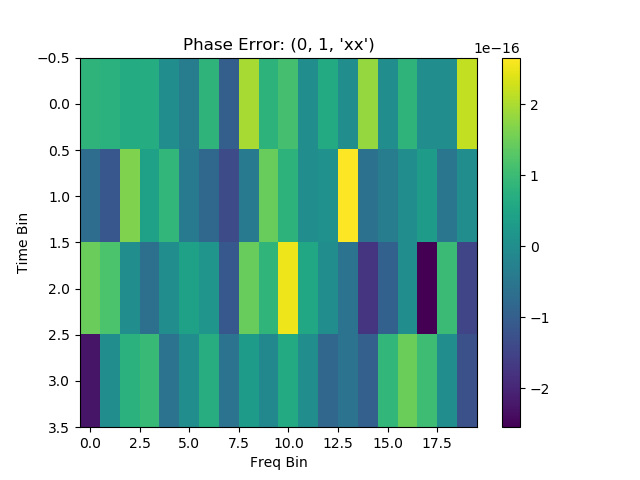

Text(0,0.5,u'Time Bin')

In [15]:
plt.figure()
bl = (0,1,'xx')
plt.imshow(np.angle(AC.data[bl] / true_vis[bl]), aspect='auto')
plt.colorbar()
plt.title('Phase Error: ' + str(bl))
plt.xlabel('Freq Bin')
plt.ylabel('Time Bin')

<IPython.core.display.Javascript object>


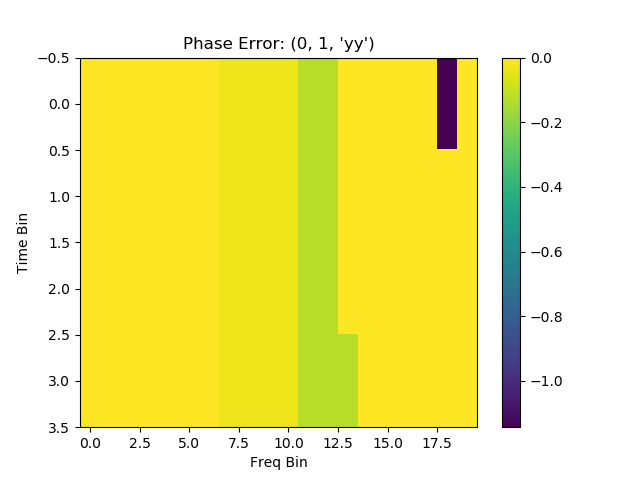

<IPython.core.display.Javascript object>


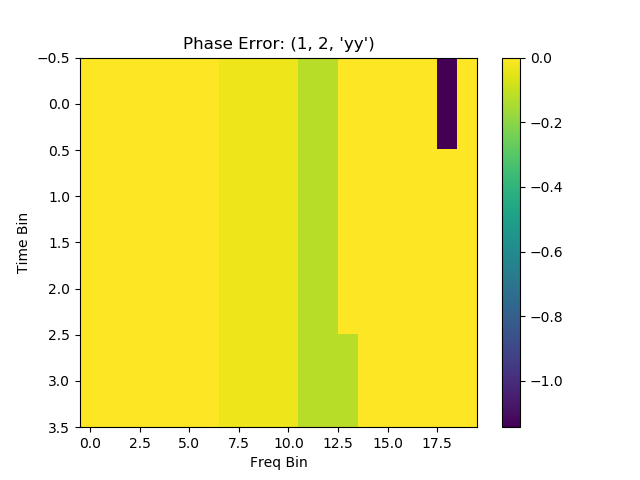

Text(0,0.5,u'Time Bin')

In [16]:
plt.figure()
bl = (0,1,'yy')
plt.imshow(np.angle(AC.data[bl] / true_vis[bl]), aspect='auto')
plt.colorbar()
plt.title('Phase Error: ' + str(bl))
plt.xlabel('Freq Bin')
plt.ylabel('Time Bin')

plt.figure()
bl = (1,2,'yy')
plt.imshow(np.angle(AC.data[bl] / true_vis[bl]), aspect='auto')
plt.colorbar()
plt.title('Phase Error: ' + str(bl))
plt.xlabel('Freq Bin')
plt.ylabel('Time Bin')

<IPython.core.display.Javascript object>


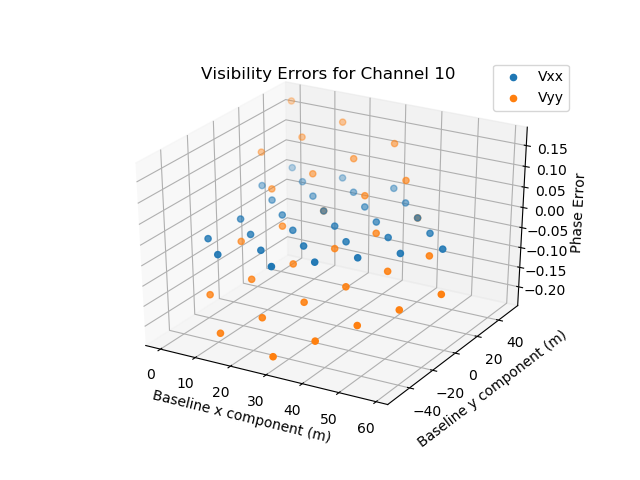

Text(0.5,0.92,u'Visibility Errors for Channel 10')

In [17]:
chan = 10
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
blvecs = np.array([antpos[red[0][1]] - antpos[red[0][0]] for red in reds if red[0][2] == 'xx'])
xx_phs_errs = np.array([np.angle(AC.data[red[0]][0,chan] / true_vis[red[0]][0,chan]) for red in reds if red[0][2] == 'xx'])
yy_phs_errs = np.array([np.angle(AC.data[red[0]][0,chan] / true_vis[red[0]][0,chan]) for red in reds if red[0][2] == 'yy'])
ax.scatter3D(blvecs[:,0], blvecs[:,1], xx_phs_errs)
ax.scatter3D(blvecs[:,0], blvecs[:,1], yy_phs_errs)
ax.set_xlabel('Baseline x component (m)')
ax.set_ylabel('Baseline y component (m)')
ax.set_zlabel('Phase Error')
plt.legend(['Vxx','Vyy'])
plt.title('Visibility Errors for Channel ' + str(chan))

# Plotting phase errors before abscal

In [18]:
model = deepcopy(true_vis)
gain_list = []
AC = hc.abscal.AbsCal(model, deepcopy(vis_sols), antpos=antpos, freqs=freqs)

# AC.phs_logcal(avg=True, verbose=True)
# AC.data = hc.abscal.apply_gains(AC.data, AC.ant_phi_gain, gain_convention='divide')

AC.delay_slope_lincal(verbose=True, time_avg=True)
AC.data = hc.abscal.apply_gains(AC.data, AC.dly_slope_gain, gain_convention='divide')
gain_list.append(AC.dly_slope_gain)

AC.abs_amp_logcal(verbose=True)
AC.data = hc.abscal.apply_gains(AC.data, AC.abs_eta_gain, gain_convention='divide')
gain_list.append(AC.abs_eta_gain)

# AC.TT_phs_logcal(verbose=True)
# AC.data = hc.abscal.apply_gains(AC.data, AC.TT_Phi_gain, gain_convention='divide')
# gain_list.append(AC.TT_Phi_gain)

abscal_gain_dict = hc.abscal.merge_gains(gain_list)

abs_omni_gains = {ant: abscal_gain_dict[ant] * g[ant] for ant in g.keys()}

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve


<IPython.core.display.Javascript object>


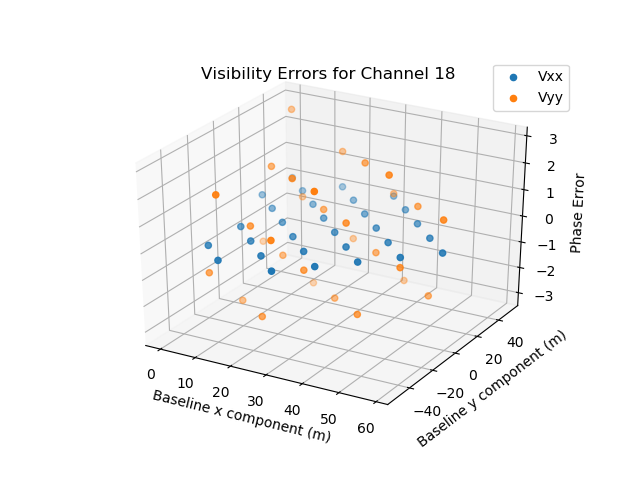

Text(0.5,0.92,u'Visibility Errors for Channel 18')

In [19]:
chan = 18
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
blvecs = np.array([antpos[red[0][1]] - antpos[red[0][0]] for red in reds if red[0][2] == 'xx'])
xx_phs_errs = np.array([np.angle(AC.data[red[0]][0,chan] / true_vis[red[0]][0,chan]) for red in reds if red[0][2] == 'xx'])
yy_phs_errs = np.array([np.angle(AC.data[red[0]][0,chan] / true_vis[red[0]][0,chan]) for red in reds if red[0][2] == 'yy'])
ax.scatter3D(blvecs[:,0], blvecs[:,1], xx_phs_errs)
ax.scatter3D(blvecs[:,0], blvecs[:,1], yy_phs_errs)
ax.set_xlabel('Baseline x component (m)')
ax.set_ylabel('Baseline y component (m)')
ax.set_zlabel('Phase Error')
plt.legend(['Vxx','Vyy'])
plt.title('Visibility Errors for Channel ' + str(chan))

In [20]:
# try running this on real data

In [32]:
from collections import OrderedDict as odict
test = {i: np.random.randn() for i in np.arange(10)[::-1]}
print test
test = odict(sorted(test.items()))
print test

{0: 1.2687784541452989, 1: -0.372153474789223, 2: -1.4677759778283315, 3: 0.982697646630318, 4: 0.219249008066503, 5: 1.9638844578650088, 6: -1.6418788204628212, 7: -0.7967271816089406, 8: -0.9874308280259974, 9: 0.22778412792642416}
OrderedDict([(0, 1.2687784541452989), (1, -0.372153474789223), (2, -1.4677759778283315), (3, 0.982697646630318), (4, 0.219249008066503), (5, 1.9638844578650088), (6, -1.6418788204628212), (7, -0.7967271816089406), (8, -0.9874308280259974), (9, 0.22778412792642416)])
